In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext dotenv
%dotenv

import datetime
import os
import random
import time
import sys

import imgaug
import matplotlib.pyplot as plt
import numpy as np
import skimage.io
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
sess_config = tf.ConfigProto()

COCO_DATA = os.getenv("COCO_DATA")
MASK_RCNN_MODEL_PATH = os.getenv("MASK_RCNN_MODEL_PATH")
MODEL_DIR = os.getenv("MODEL_DIR")

if MASK_RCNN_MODEL_PATH not in sys.path:
    sys.path.append(MASK_RCNN_MODEL_PATH)
    
from samples.coco import coco

from mrcnn import utils
from mrcnn import model as modellib
from mrcnn import visualize
    
from lib import utils as siamese_utils
from lib import model as siamese_model
from lib import config as siamese_config




Using TensorFlow backend.


### Dataset

In [2]:
index = 1
one_shot_classes = np.array([4*i + index for i in range(20)])
train_classes = np.array(range(1,81))[np.array([i not in one_shot_classes for i in range(1,81)])]

In [3]:
# Load COCO/val dataset
coco_val = siamese_utils.IndexedCocoDataset()
coco_object = coco_val.load_coco(COCO_DATA, subset="val", year="2017", return_coco=True)
coco_val.prepare()
coco_val.build_indices()
coco_val.ACTIVE_CLASSES = one_shot_classes

loading annotations into memory...
Done (t=0.47s)
creating index...
index created!


### Model

In [4]:
class LargeEvalConfig(siamese_config.Config):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1
    NAME = 'coco'
    EXPERIMENT = 'evaluation'
    CHECKPOINT_DIR = 'checkpoints/'
    NUM_TARGETS = 1
    
    # Large image sizes
    TARGET_MAX_DIM = 192
    TARGET_MIN_DIM = 150
    IMAGE_MIN_DIM = 800
    IMAGE_MAX_DIM = 1024
    # Large model size
    FPN_CLASSIF_FC_LAYERS_SIZE = 1024
    FPN_FEATUREMAPS = 256
    # Large number of rois at all stages
    RPN_ANCHOR_STRIDE = 1
    RPN_TRAIN_ANCHORS_PER_IMAGE = 256
    POST_NMS_ROIS_TRAINING = 2000
    POST_NMS_ROIS_INFERENCE = 1000
    TRAIN_ROIS_PER_IMAGE = 200
    DETECTION_MAX_INSTANCES = 100
    MAX_GT_INSTANCES = 100
    

class SmallEvalConfig(siamese_config.Config):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1
    NAME = 'coco'
    EXPERIMENT = 'evaluation'
    CHECKPOINT_DIR = 'checkpoints/'
    NUM_TARGETS = 1

In [5]:
model_size = 'large'
#model_size = 'small'

In [6]:
if model_size == 'small':
    config = SmallEvalConfig()
elif model_size == 'large':
    config = LargeEvalConfig()
    
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
CHECKPOINT_DIR                 checkpoints/
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.5
EXPERIMENT                     evaluation
FPN_CLASSIF_FC_LAYERS_SIZE     1024
FPN_FEATUREMAPS                256
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.02
LOSS_WEIGHTS                   {'rpn_class_loss': 2.0, 'rpn_bbox_loss': 0.1, 'mrcnn_class_loss': 2.0, 'mrcnn_bbox_los

In [7]:
#Select checkpoint
if model_size == 'small':
    checkpoint = 'checkpoints/small_siamese_mrcnn_0160.h5'
elif model_size == 'large':
    checkpoint = 'checkpoints/large_siamese_mrcnn_0320.h5'

### Visualization

In [8]:
# Create model object in inference mode.
model = siamese_model.SiameseMaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)
model.load_checkpoint(checkpoint)

loading checkpoints/large_siamese_mrcnn_0320.h5 ...
starting from epoch 320


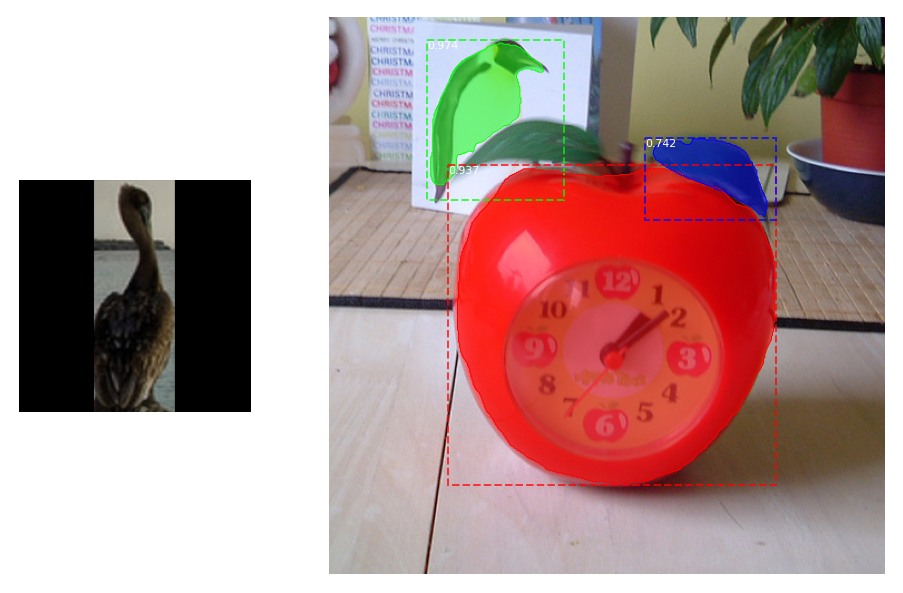

In [9]:
# Select category
category = 15
image_id = np.random.choice(coco_val.category_image_index[category])
# Load target
target = siamese_utils.get_one_target(category, coco_val, config)
# Load image
image = coco_val.load_image(image_id)

# Run detection
results = model.detect([[target]], [image], verbose=0)
r = results[0]
# Display results
siamese_utils.display_results(target, image, r['rois'], r['masks'], r['class_ids'], r['scores'])